## 1. Load package

In [8]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

## 2. Load data

In [9]:
# dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/030results_cistopic/040dars/markers_dict_pycisTopic_leiden_10_0.5.pkl', 'rb'))
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_dict.pkl', 'rb'))

In [10]:
concatenated_df = pd.concat(
    [df.assign(key=key) for key, df in dar_markers.items()],
    ignore_index=False
)
concatenated_df = concatenated_df.reset_index()
concatenated_df[['chr', 'start', 'end']] = concatenated_df['index'].str.split(':|-', expand=True)
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)

concatenated_df = concatenated_df.drop(columns=['index'])
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)
concatenated_df = concatenated_df[['chr', 'start', 'end'] + [col for col in concatenated_df.columns if col not in ['chr', 'start', 'end']]]
duckdb.register('peaks', concatenated_df)

In [11]:
parquet_file_path="/lustre1/project/stg_00079/students/tingting/data/GWAS/020results_expansion/Bellenguez_etal_Stage1_result.expanded.parquet"
snps=duckdb.read_parquet(parquet_file_path)
query=f"""
SELECT * from snps
"""
snps_df=duckdb.query(query).df()
print(f'lead snps: {snps_df.shape[0]}')
ld_buddies = snps_df.loc[(snps_df['rsid'] != '.') & (snps_df['r_square'] != '.'), :].shape[0]
print(f'ld buddies: {ld_buddies}')
snps_df['r_square'] = np.where(snps_df['r_square'] != '.', snps_df['p_value'], snps_df['r_square'])
duckdb.register('snps', snps_df)

query = f"""
SELECT Chromosome,
       start_pos,
       snp_pos,
       rsid,
       r_square AS stats
FROM snps

UNION ALL

SELECT Chromosome_AD AS Chromosome, 
       start_pos_AD AS start_pos, 
       snp_pos_AD AS snp_pos, 
       rsid_AD AS rsid, 
       p_value AS stats
FROM snps;
"""

snps_long = duckdb.query(query).df()

snps_long['stats'] = pd.to_numeric(snps_long['stats'], errors='coerce')
filtered_df = snps_long.dropna(subset=['stats'])
print(sum(filtered_df.duplicated()))

lead snps: 3298115
ld buddies: 857606
897134


In [12]:
857606/3298115

0.2600291378560178

In [13]:
df=filtered_df.drop_duplicates()
duckdb.register('snps', df)

In [14]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.key,
    pk.Log2FC,
    pk.Adjusted_pval,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.stats
FROM
    snps s
JOIN
    peaks pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.end;
"""
snps_peaks_joined_table=duckdb.query(query).df()

In [15]:
sum(snps_peaks_joined_table.duplicated())

0

In [17]:
snps_peaks_joined_table.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,stats
0,chr9,89154555,7,-0.712312,5.489011e-309,89154847,89154848,rs1888642,0.000367
1,chr8,11864929,7,-0.705707,0.000000e+00,11865375,11865376,rs558623746,0.000380
2,chr22,39269383,7,-0.663494,6.810442e-280,39269389,39269390,rs1569497,0.000371
3,chr6,41162946,7,-0.680492,0.000000e+00,41162954,41162955,rs2234250,0.000374
4,chr8,17720846,7,-0.664925,1.411870e-307,17721280,17721281,rs6981770,0.000378


In [21]:
snps_peaks_joined_table['-log_pval'] = -np.log10(snps_peaks_joined_table['stats'] + 1e-10)  

In [18]:
def plot_count(lfc, pval):
    counts = snps_peaks_joined_table[(snps_peaks_joined_table['Log2FC'] > lfc)&(snps_peaks_joined_table['Adjusted_pval'] <pval)]['key'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    bars=plt.bar(counts.index, counts.values)
    plt.xlabel('Clusters')
    plt.ylabel('Count SNPS per cluster')
    plt.title(f'Count of SNPs (p-value<-0.1) per cluster (adj-pval<{pval}, LFC>{lfc})')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')
    plt.tight_layout()
    plt.show()

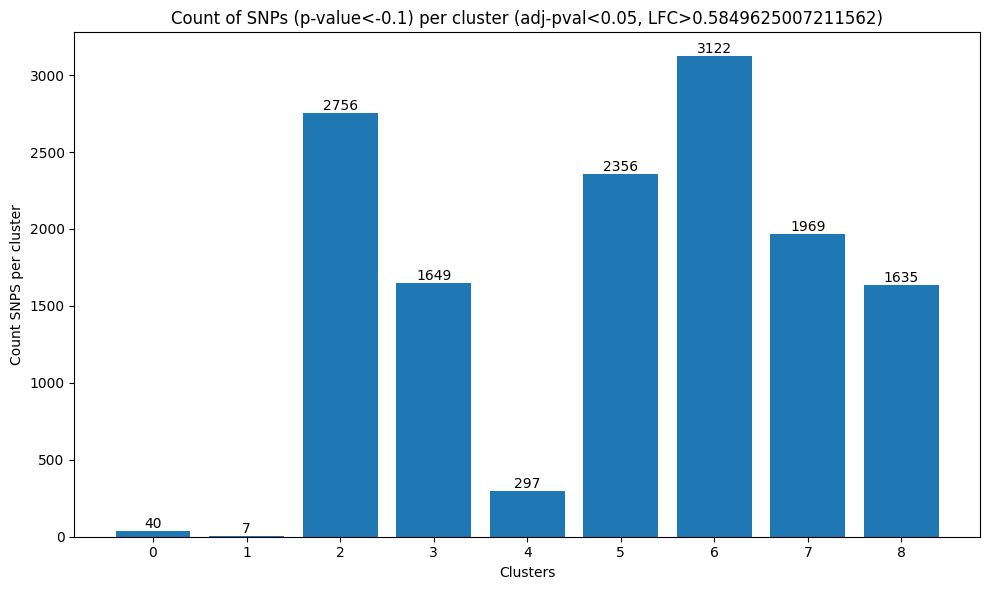

In [19]:
plot_count(np.log2(1.5), 0.05)

In [23]:
threshold = -np.log10(0.05)
genomewideline= -np.log10(5e-8)
suggestive= -np.log10(1e-5)
snps_peaks_joined_table=snps_peaks_joined_table[(snps_peaks_joined_table['Log2FC'] > np.log2(1.5))&(snps_peaks_joined_table['Adjusted_pval'] <0.05)]
results = {
    'Cluster': [],
    'Not_significant': [],
    'Significant': [],
    'Suggestive': [],
    'Genomewideline': []
}

# Iterate through each unique cluster
for i in snps_peaks_joined_table['key'].unique():
    results['Cluster'].append(f'cluster{i}')
    
    # Not significant
    not_significant_count = snps_peaks_joined_table[
        (snps_peaks_joined_table['key'] == i) & 
        (snps_peaks_joined_table['-log_pval'] < threshold)
    ].shape[0]
    results['Not_significant'].append(not_significant_count)
    
    # Significant
    significant_count = snps_peaks_joined_table[
        (snps_peaks_joined_table['key'] == i) & 
        (snps_peaks_joined_table['-log_pval'] >= threshold) & 
        (snps_peaks_joined_table['-log_pval'] < suggestive)
    ].shape[0]
    results['Significant'].append(significant_count)
    
    # Suggestive
    suggestive_count = snps_peaks_joined_table[
        (snps_peaks_joined_table['key'] == i) & 
        (snps_peaks_joined_table['-log_pval'] >= suggestive) & 
        (snps_peaks_joined_table['-log_pval'] < genomewideline)
    ].shape[0]
    results['Suggestive'].append(suggestive_count)
    
    # Genomewideline
    genomewideline_count = snps_peaks_joined_table[
        (snps_peaks_joined_table['key'] == i) & 
        (snps_peaks_joined_table['-log_pval'] >= genomewideline)
    ].shape[0]
    results['Genomewideline'].append(genomewideline_count)

# Convert the results dictionary to a DataFrame
df = pd.DataFrame(results)

# Set the 'Cluster' column as the index
df.set_index('Cluster', inplace=True)

# Display the DataFrame
print(df)

          Not_significant  Significant  Suggestive  Genomewideline
Cluster                                                           
cluster6             1446         1626          30              20
cluster7              916         1032          13               8
cluster5             1081         1241          27               7
cluster8              761          863          10               1
cluster3              733          887          13              16
cluster2             1332         1410          13               1
cluster0               16           24           0               0
cluster4              152          141           1               3
cluster1                2            5           0               0


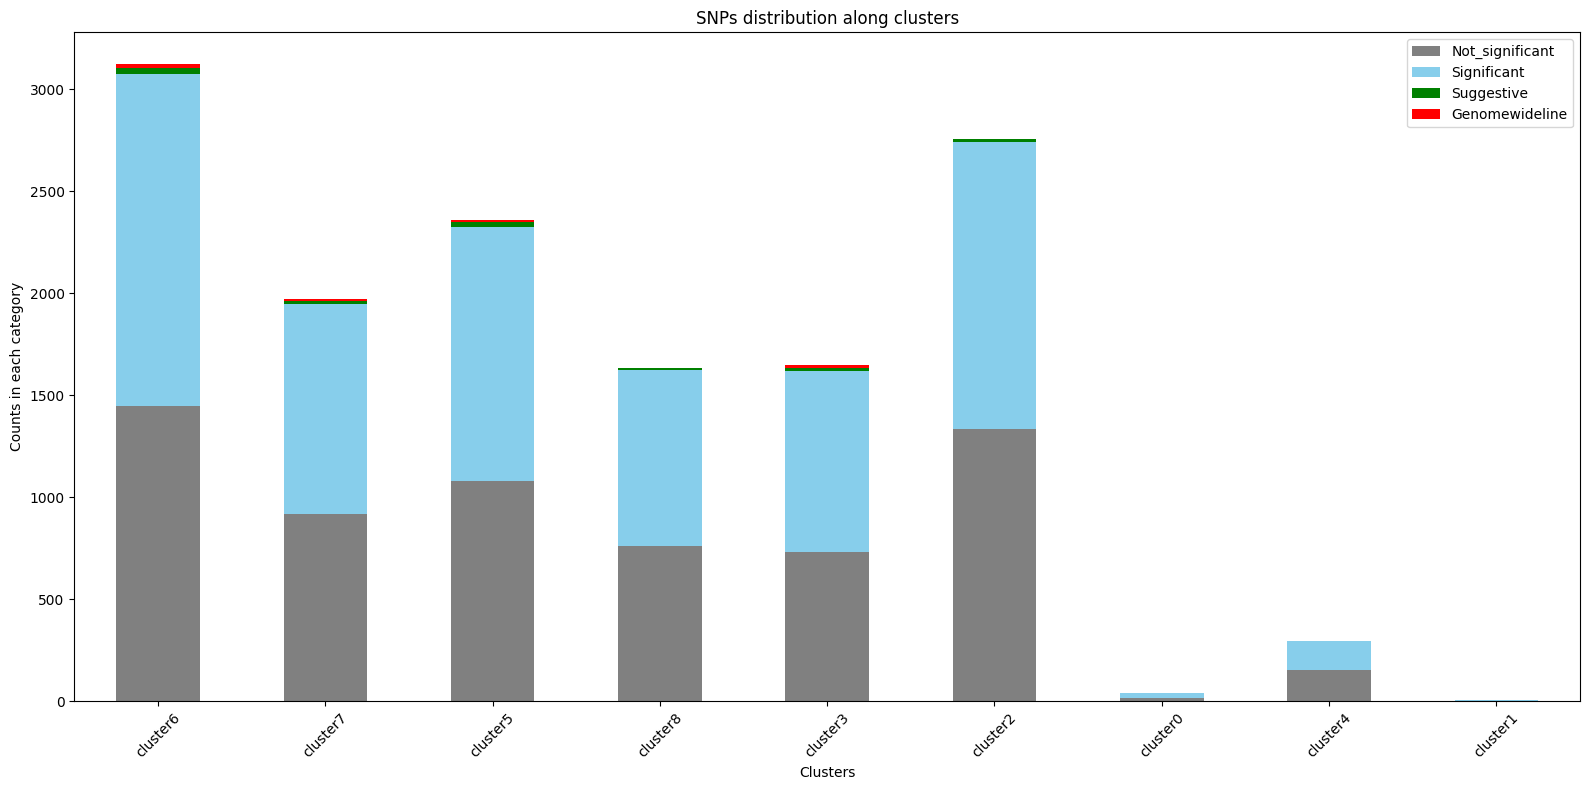

In [24]:
ax = df.plot(kind='bar', stacked=True, color=['gray', 'skyblue', 'green', 'red'], figsize=(16, 8))

# # Adding annotations
# for container in ax.containers:
#     ax.bar_label(container, label_type='center')

# Customize plot
plt.xlabel('Clusters')
plt.ylabel('Counts in each category')
plt.title('SNPs distribution along clusters')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()